<h1>Разведочный анализ данных</h1>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import warnings
import gc
import matplotlib.pyplot as plt
from typing import TypeVar
import numpy as np
import seaborn as sns
import scipy
from sklearn.metrics import f1_score, mean_absolute_error
from tqdm import notebook
from sklearn import ensemble, model_selection, neighbors
import catboost as cb
import pickle

gc.enable()
warnings.filterwarnings("ignore")

Определим необходимые переменные и функции

In [2]:
dataframe = TypeVar("dataframe", bound=pd.core.frame.DataFrame)

In [3]:
def type_cast(df: dataframe) -> dataframe:
    cols = tuple(df)
    for col in cols:
        current_max = df[col].max()
        current_min = df[col].min()
        current_type = str(df[col].dtype)[0]
        if current_type in ('i', 'f'):
            if current_type == 'i':
                if (current_max < np.iinfo(np.int8).max) & (current_min > np.iinfo(np.int8).min):
                    df[col] = df[col].astype(np.int8)
                elif (current_max < np.iinfo(np.int16).max) & (current_min > np.iinfo(np.int16).min):
                    df[col] = df[col].astype(np.int16)
                elif (current_max < np.iinfo(np.int32).max) & (current_min > np.iinfo(np.int32).min):
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                df[col] = df[col].astype(np.float32)
    return df

Загрузим данные

In [4]:
data = pd.read_csv("data/credit_scoring.csv")
print(data.shape)
data.sample(3)

(150000, 12)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
4256,1,0.364406,63.0,1,2582.000000,NaN,9,0,0,0.0,B,d
98165,0,0.330630,71.0,0,0.219528,4495.0,10,0,0,0.0,A,e
12194,1,1.024337,31.0,0,0.541676,4666.0,10,0,0,1.0,A,b


Посмотрим на распределение целевой переменной

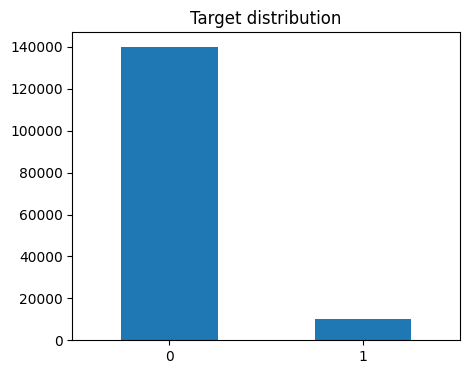

In [5]:
plt.figure(figsize=(5, 4))
data["SeriousDlqin2yrs"].value_counts().plot(kind="bar", rot=0)
plt.title("Target distribution")
plt.show()

Имеем дело с сильно несбалансированным датасетом

Проверим данные на наличие дубликатов

In [6]:
data.duplicated().sum()

634

Почти 0.5% данных составляют дубликаты. Удалим эти объекты

In [7]:
data.drop(
    data.loc[data.duplicated()].index,
    axis=0,
    inplace=True
)
data.reset_index(drop=True, inplace=True)

Выполним проверку на отсутсвие/ присутствие пропусков в данных

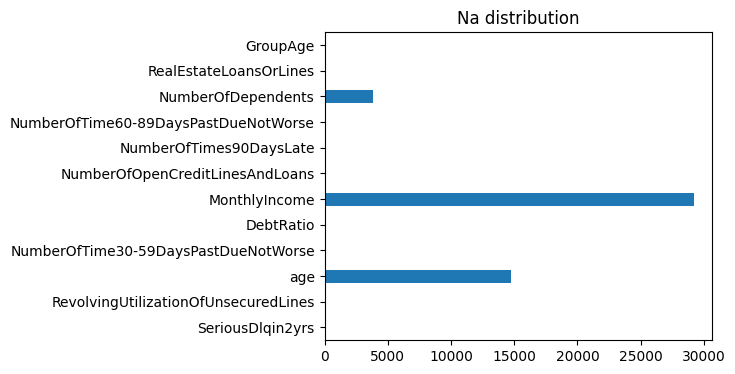

In [8]:
plt.figure(figsize=(5, 4))
data.isna().sum().plot(kind="barh", rot=0)
plt.title("Na distribution")
plt.show()

По трём переменным имеются пропуски:
- максимальное кол-во пропусков достигает почти 20% от общего объёма данных (`MonthlyIncome`);
- минимальное кол-во пропусков составляет ~ 2,6% от общего объёма данных (`NumberOfDependents`);
- по перемнной `age` имеются пропуски. Однако в данных присутствует её бинаризованный вариант - `GroupAge`, который не имеет пропуски.

Посмотрим на распределение типов в данных

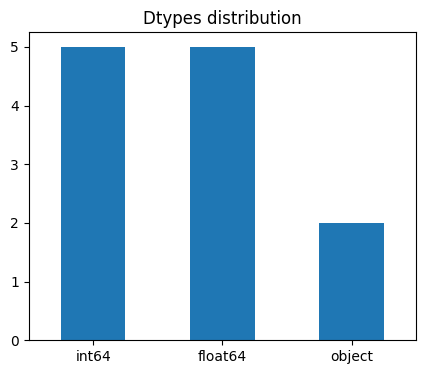

In [9]:
plt.figure(figsize=(5, 4))
data.dtypes.value_counts().plot(kind="bar", rot=0)
plt.title("Dtypes distribution")
plt.show()

В данных присутствует всего две номинативные переменные, значения которых необходимо закодировать соответствующим образом

Посмотрим на потребление памяти  
Большой расход памяти привнесёт в работу с данными большие неудобства

In [10]:
data.memory_usage().sum() / 1024** 2

13.67498779296875

In [11]:
150_000 - 127919

22081

Потребление памяти is `13.7Мб`. Довольно низкий показатель, но его можно сделать ещё ниже

Выполним приведение типов признаков к более эффективным, чтобы уменьшить потребление памяти

In [12]:
data = type_cast(data)
data.memory_usage().sum() / 1024** 2

5.840429306030273

Удалось сократить потребление памяти почти в `2.5` раза  
(Конечно, распределние типов данных поменялось) 

Данные содержат 2 номинативные переменные, посмотрим на их значения и распределения

In [13]:
cat_features = ["RealEstateLoansOrLines", "GroupAge"]
for col in cat_features:
    print(data[col].value_counts())
    print(70 * '=')

A    139414
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64
d    47168
e    42652
c    42404
b    17141
a        1
Name: GroupAge, dtype: int64


`RealEstateLoansOrLines` представляет кол-во кредитов. Чем дальше литерал от начала алфавита, тем больше это число. Имеем дело с ординальной переменной. Это означает, что для элементов данного множества можно ввести отношение порядка. Элементы же данного множества можно закодивать ASCII кодами.  
Аналогичные манипуляции можно проделять и для  `GroupAge`, но пусть пока эти переменные останутся без изменений

Посмотрим на распределение возрастов

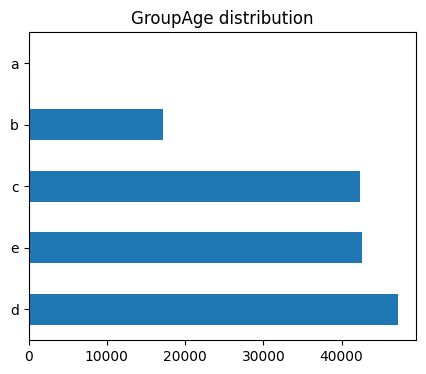

In [14]:
plt.figure(figsize=(5, 4))
data["GroupAge"].value_counts().plot(kind="barh", rot=0)
plt.title("GroupAge distribution")
plt.show()

Сильное смущение вызывает самая первая категория. Рассмотрим её подробнее

In [15]:
data[data["GroupAge"] == 'a']

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
41603,0,1.0,0.0,1,0.436927,6000.0,6,0,0,2.0,A,a


Возраст - 0 лет...  
В РФ кредиты можно получать только при достижении полной дееспособности, т.е. с 18 лет. Однако в большинстве банков этот порог приравнен к 21.  
Учитывая это плюс чудовищно низкую частоту встречаемости данной возрастной группы, удалим этот объект из данных

In [16]:
data.drop(
    data[data["GroupAge"] == 'a'].index,
    axis=0,
    inplace=True
)

data.reset_index(drop=True, inplace=True)

Остальные градации `GroupAge` представляют собой следующие возрастные группы:

In [17]:
for age_group in sorted(data["GroupAge"].unique()):
    tmp = data[data["GroupAge"] == age_group]["age"]
    print(f"[{age_group}]: min - {tmp.min()} /// max - {tmp.max()}")

[b]: min - 21.0 /// max - 34.0
[c]: min - 35.0 /// max - 49.0
[d]: min - 50.0 /// max - 64.0
[e]: min - 65.0 /// max - 109.0


- b: от 21 до 35;
- c: от 35 до 50;
- d: от 50 до 65;
- e: от 65.

Из-за наличия пропусков по `age` и, учитывая тот факт, что `GroupAge` - это бинаризованная версия `age`, удалим `age` 

In [18]:
data.drop("age", axis=1, inplace=True)

Кажется, что возрастные группы равномерно распределены. Проверим эту гипотезу с помощью критерия $\chi^2$

$H_0$: распределение возрастных групп подчиняется равномерному закону  
$H_1$: распределение не подчиняется равномерному закону

In [19]:
f_obs = data["GroupAge"].value_counts().values
f_exp = np.asarray([f_obs.sum() / len(f_obs)] * len(f_obs))
scipy.stats.chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=14955.327385933786, pvalue=0.0)

Распределение возрастных групп не подчиняется равномерному закону распределения, т.к `p-value < 0.05`

Посмотрим на распределение кол-ва кредитов

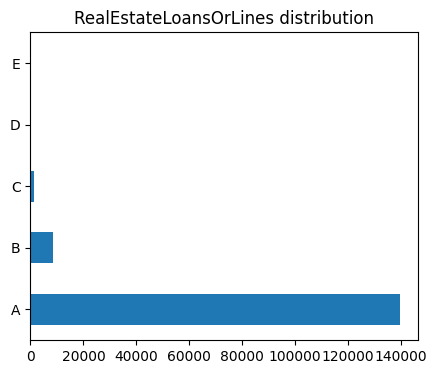

In [20]:
plt.figure(figsize=(5, 4))
data["RealEstateLoansOrLines"].value_counts().plot(kind="barh", rot=0)
plt.title("RealEstateLoansOrLines distribution")
plt.show()

Сильно доминирует градация - А (её порядок $10^5$), в том время как градиций E и D не видно, потому что их порядок $10^1$. По порядку градации B и С равны  
Также стоит отметить, что на графике представлено сильно скошенное распределение

Посмотрим, как распределяются градации номинативных переменных относительно целевого признака

In [21]:
pd.crosstab(data["SeriousDlqin2yrs"], data["GroupAge"])

GroupAge,b,c,d,e
SeriousDlqin2yrs,,,,
0,15216,38706,44477,40957
1,1925,3698,2691,1695


Видно, что распределение скошено в сторону тех, кто не имел просрочку 90/ 90+ дней

In [22]:
pd.crosstab(data["SeriousDlqin2yrs"], data["RealEstateLoansOrLines"])

RealEstateLoansOrLines,A,B,C,D,E
SeriousDlqin2yrs,,,,,
0,130245,7854,1184,65,8
1,9168,616,204,19,2


Кол-во кредитов не влияет на возможность просрочки 90 или 90+ дней, т.к. опять распределение скошено в сторону тех, кто не имел подобной просрочки

Для континуальных переменных построим boxplot'ы

In [23]:
num_features = data.dtypes.index[1:-2]
len(num_features)

8

In [24]:
data[num_features].dtypes

RevolvingUtilizationOfUnsecuredLines    float32
NumberOfTime30-59DaysPastDueNotWorse       int8
DebtRatio                               float32
MonthlyIncome                           float32
NumberOfOpenCreditLinesAndLoans            int8
NumberOfTimes90DaysLate                    int8
NumberOfTime60-89DaysPastDueNotWorse       int8
NumberOfDependents                      float32
dtype: object

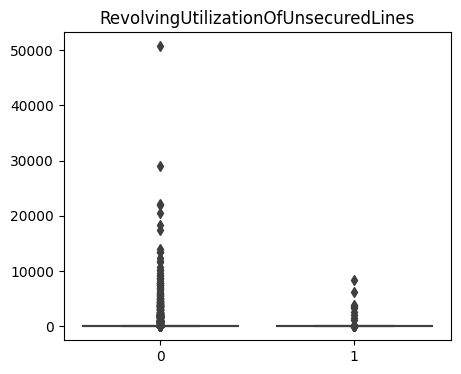

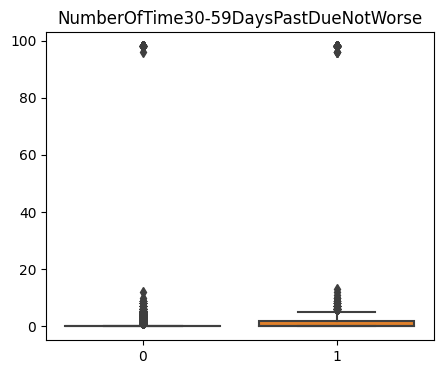

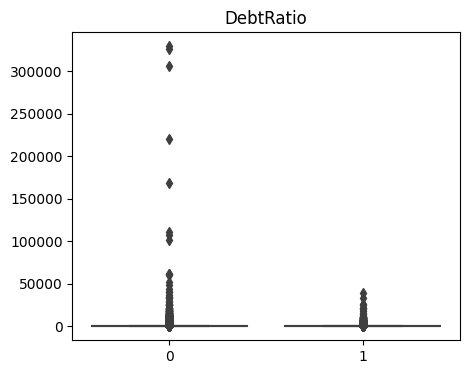

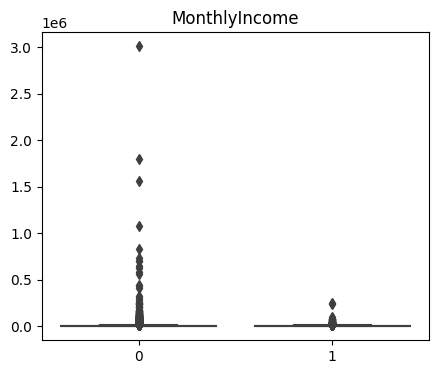

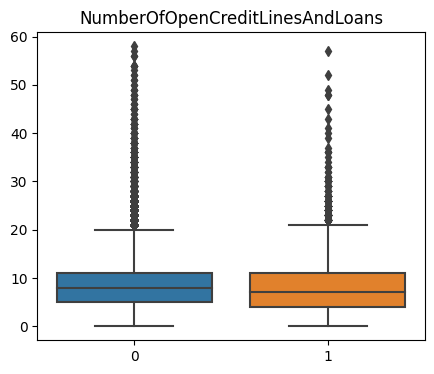

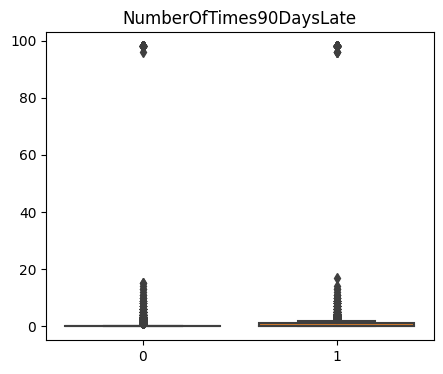

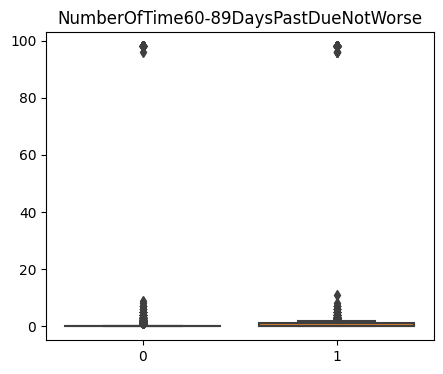

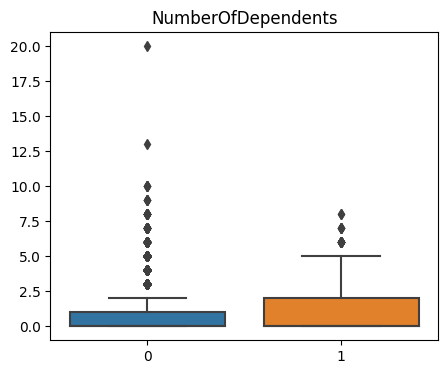

In [25]:
for name in num_features:
    plt.figure(figsize=(5, 4))
    sns.boxplot([
        data[data["SeriousDlqin2yrs"] == 0][name],
        data[data["SeriousDlqin2yrs"] == 1][name]
    ])
    plt.title(name)
    plt.show()

Из boxplot'ов видно, что средние по группам особо не отличаются  
Тест Стьюдента проводить не имеет смысла, т.к.
- средние статистически значимо отличаться не будут;
- данные распределены не нормальным образом;
- а также вопрос о гомогенности дисперсий открыт

Из полученных графиков подробнее рассмотрим признаки, связанные с кол-вом просрочек  
По остальным переменным явно видно, что средние двух групп не отличаются друг от друга

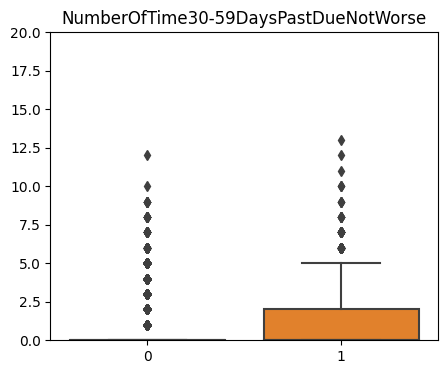

In [26]:
plt.figure(figsize=(5, 4))
sns.boxplot([
    data[data["SeriousDlqin2yrs"] == 0]["NumberOfTime30-59DaysPastDueNotWorse"],
    data[data["SeriousDlqin2yrs"] == 1]["NumberOfTime30-59DaysPastDueNotWorse"]
])
plt.ylim([0, 20])
plt.title("NumberOfTime30-59DaysPastDueNotWorse")
plt.show()

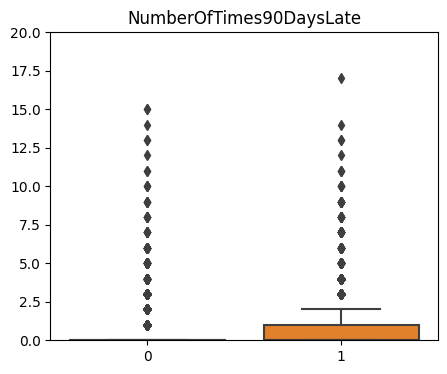

In [27]:
plt.figure(figsize=(5, 4))
sns.boxplot([
    data[data["SeriousDlqin2yrs"] == 0]["NumberOfTimes90DaysLate"],
    data[data["SeriousDlqin2yrs"] == 1]["NumberOfTimes90DaysLate"]
])
plt.ylim([0, 20])
plt.title("NumberOfTimes90DaysLate")
plt.show()

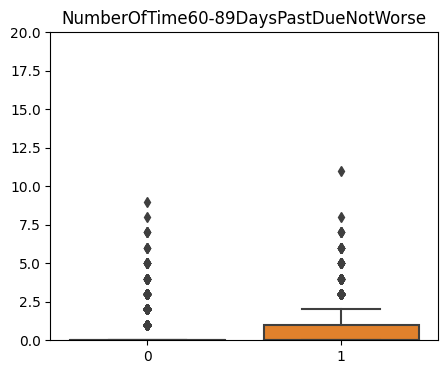

In [28]:
plt.figure(figsize=(5, 4))
sns.boxplot([
    data[data["SeriousDlqin2yrs"] == 0]["NumberOfTime60-89DaysPastDueNotWorse"],
    data[data["SeriousDlqin2yrs"] == 1]["NumberOfTime60-89DaysPastDueNotWorse"]
])
plt.ylim([0, 20])
plt.title("NumberOfTime60-89DaysPastDueNotWorse")
plt.show()

Очевидно, что среднее кол-во дней просрочки у нулевой группы равно 0, т.к. эти люди в среднем, в общем и целом, не имеют задолженностей   
Кажется, что если изначально была просрочка более 30 дней, то она может тянуться и дальше. Проверим эту гипотезу, построив матрицу корреляций

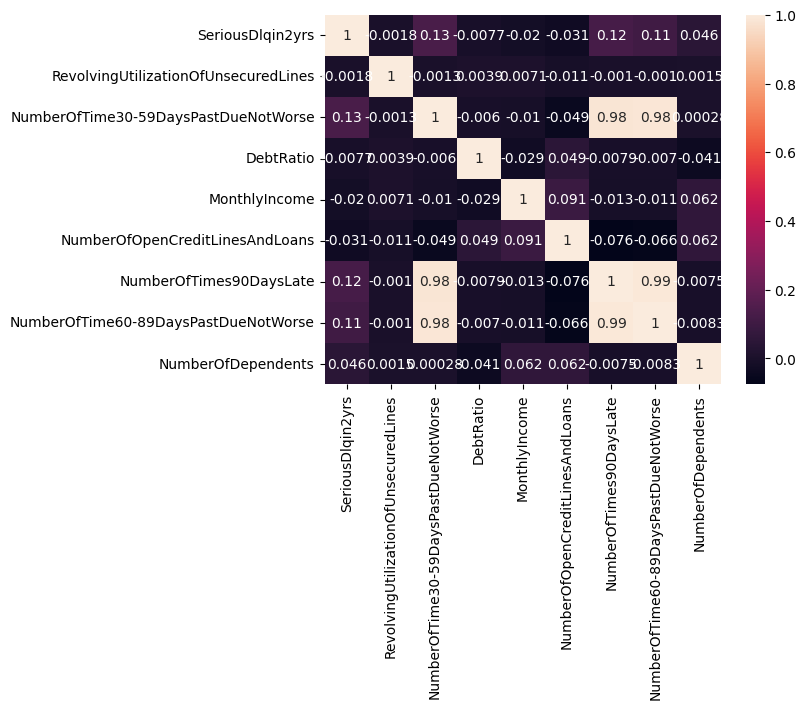

In [29]:
sns.heatmap(data.corr(), annot=True);

Гипотеза со связью просрочек подтвержается. Из тепловой карты корреляций виден триплет,имеющий по таблице Чеддока весьма высокую силу корреляционной связи. От двух представителей этого триплета необходимо избавиться, т.к. наличие таких признаков привносит вместе с собой проблему мультиколлинеарности  
Бинаризируем эти переменные, и если тенденция сохранится, то удалим два из трёх признаков этого триплета

In [30]:
for col in ("NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"):
    data[col] = data[col].apply(lambda x: 1 if x > 0 else 0)

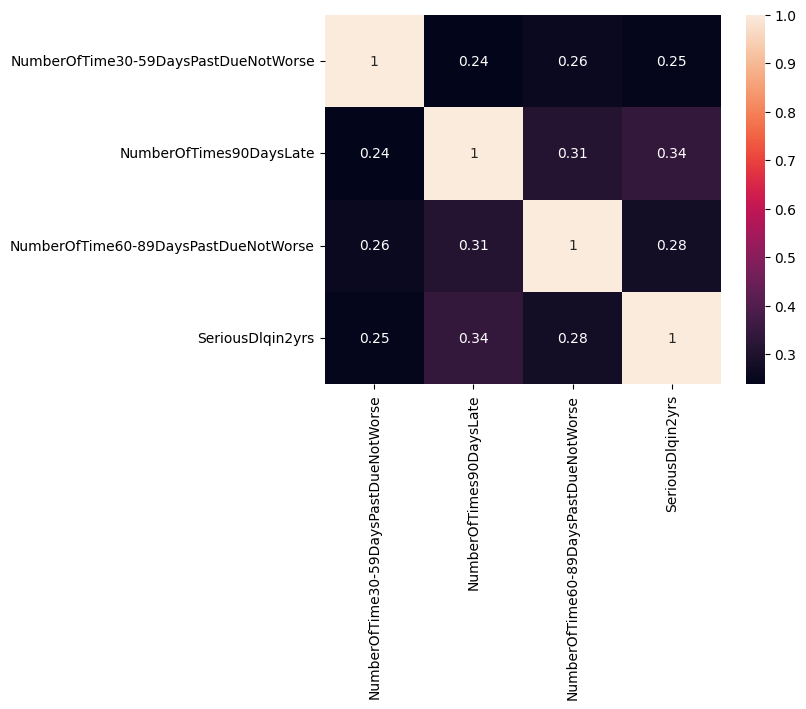

In [31]:
sns.heatmap(data[list(filter(lambda x: "time" in x.lower(), num_features)) + ["SeriousDlqin2yrs"]].corr(), annot=True);

Теснота связи с целевым признаком увеличилась, и момент, связанный с весьма сильной корреляцией признаков, пропал, что хорошо  
Значит, оставим все эти признаки для дальнейшего рассмотрения

Посмотрим на распредение децилей `DebtRatio`

In [32]:
for q in np.arange(0, 1, 0.1):
    print(f"[{round(q, 2)}]: {data['DebtRatio'].quantile(q)}")

[0.0]: 0.0
[0.1]: 0.03519436940550805
[0.2]: 0.13656125366687777
[0.3]: 0.2156422346830368
[0.4]: 0.2891877174377442
[0.5]: 0.36827340722084045
[0.6]: 0.4695077180862427
[0.7]: 0.651831245422363
[0.8]: 4.065668964386091
[0.9]: 1275.0


Значение строго меньшие 1.0 означают, что денежная сумма, уходящая на расходы, меньше дохода.  
1.0 - означает, что сколько человек заработал, столько он и потратил.  
Всё, что строго больше 1.0, означает, что человек тратит больше, чем зарабатывает. Получается данный персонаж выплачивает алименты, долги и тратит на проживание из того золотого мешочка, который давно опустел. Т.е. если мы ограничимся условием, что он не может тратить больше, чем зарабатывает, то такая ситуация невозможна.

80% данных по `DebtRatio` составляют значения, которые меньше 4. Остальные значения по IQR методу будут считать выбросами. Это можно подтвердить, построив boxplot для 80% объёма данных

<AxesSubplot: >

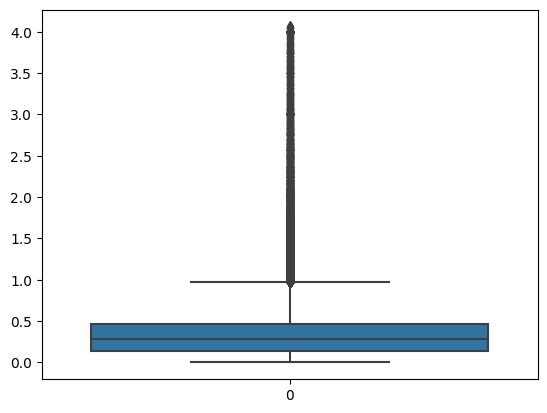

In [33]:
sns.boxplot(data[data["DebtRatio"] <= data["DebtRatio"].quantile(0.8)]["DebtRatio"])

`DebtRatio` представляет собой отношение ежемесячных расходов к ежемесячным доходам (`MonthlyIncome`)  
Если `MonthlyIncome` равен 0, то `DebtRatio` не имеет смысла в силу невозможности делениня на ноль  
Отфильтруем подобные объекты, если таковы имеются

In [34]:
print(data[data["MonthlyIncome"] == 0].shape[0])
data.drop(
    data[data["MonthlyIncome"] == 0].index,
    axis=0,
    inplace=True
)
data.reset_index(drop=True, inplace=True)

1615


Посмотрим на распределение кол-ва иждивенцев (`NumberOfDependents`)

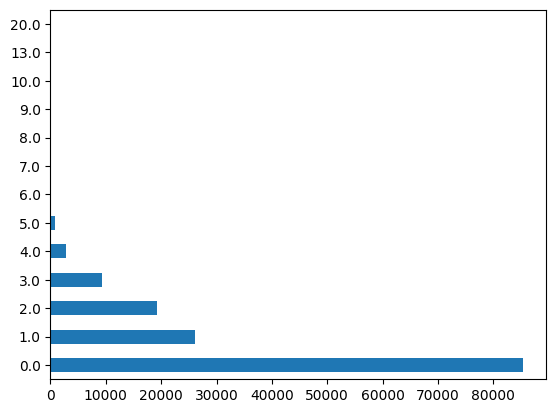

In [35]:
data["NumberOfDependents"].value_counts().plot(kind="barh", rot=0);

Как видно из полученного распределения, большинство клиентов не имеет иждивенцев  на попечении  
Видны также довольно-таки большие значения кол-ва иждивенцев (не менее 10). Посмотрим, сколько таких объектов в данных

In [36]:
data[data["NumberOfDependents"] >= 10].shape[0]

6

Таких клиентов всего 6. Возможно, их стоит удалить  
Удалим только единичные экземпляпры, а остальные оставим до этапа поиска выбросов в данных

In [37]:
data["NumberOfDependents"].value_counts()

0.0     85318
1.0     26141
2.0     19300
3.0      9361
4.0      2831
5.0       734
6.0       156
7.0        50
8.0        24
9.0         5
10.0        4
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [38]:
data.drop(
    data[data["NumberOfDependents"].isin([13, 20])].index,
    axis=0,
    inplace=True
)
data.reset_index(drop=True, inplace=True)

Посмотрим на распределение ежемесяного дохода (`MonthlyIncome`)

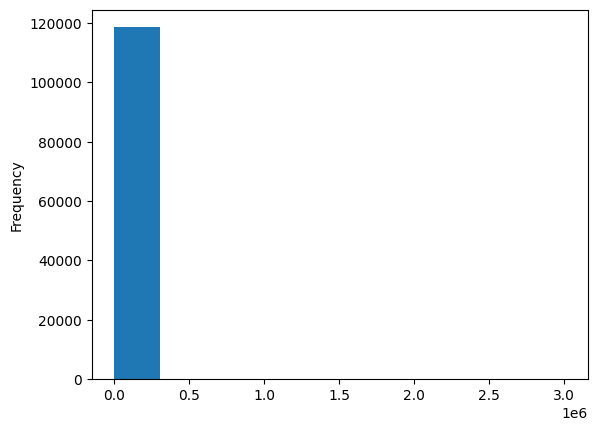

In [39]:
data["MonthlyIncome"].plot(kind="hist");

Основной объём данных сосредоточен на интервале от 0 до 0.3e6, остальные данные очень редкие и, скорее всего, представляют собой выбросы относительно общей масссы данных  
Посмотрим на распределение децилей этого признака

In [40]:
for q in np.arange(0, 1, 0.1):
    print(f"[{round(q, 2)}]: {data['MonthlyIncome'].quantile(q)}")

[0.0]: 1.0
[0.1]: 2200.0
[0.2]: 3050.0
[0.3]: 3900.0
[0.4]: 4600.0
[0.5]: 5442.0
[0.6]: 6400.0
[0.7]: 7550.0
[0.8]: 9166.0
[0.9]: 11689.7998046875


Основываясь на значениях децилей, можно оставить значения, которых лежат в диапазоне от первого дециля до девятого включительно

Посмотрим на распределение кол-ва открытых кредитов и кредитных карт (`NumberOfOpenCreditLinesAndLoans`)

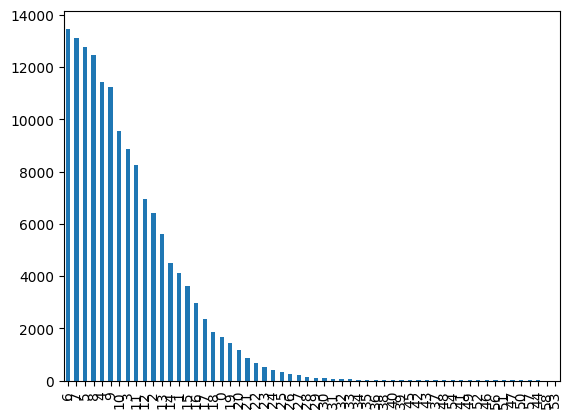

In [41]:
data["NumberOfOpenCreditLinesAndLoans"].value_counts().plot(kind="bar", rot=90);

Распределние очень похоже на плотность экспоненциального распределения  
Видно, что большинство клиентов имеет до 10 включительно кредитных продуктов (открытых кредитов и кредитных карт)  
Также видно присутствие выбросов, например, не менее 40 кредитных продуктов

Посмотрим на распределение общего баланса средств (`RevolvingUtilizationOfUnsecuredLines`)

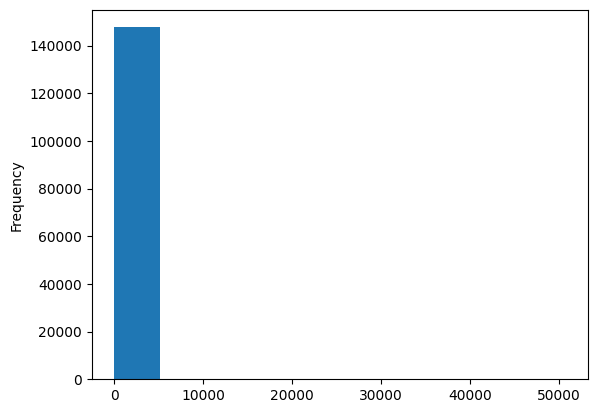

In [42]:
data["RevolvingUtilizationOfUnsecuredLines"].plot(kind="hist");

Основной объём данных сосредоточен на интервале от 0 до 5000, остальные данные очень редкие и, скорее всего, представляют собой выбросы относительно общей масссы данных

Выполним проверку на поиск дубликатов ещё раз, т.к. некоторые признаки (`NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`) были преобразованы

In [43]:
data.duplicated().sum()

922

Видим присутствие дубликатов в данных. Удалим их

In [44]:
data.drop(
    data.loc[data.duplicated()].index,
    axis=0,
    inplace=True
)
data.reset_index(drop=True, inplace=True)

Признак `NumberOfDependents` предствляется дискретным набором значений, поэтому для начала попробуем заполнить пропуски имеено по нему.  
Это необходимо, чтобы потом по всем объектам провести поиск выбросов

Стратегия заполнения пропусков следующая:
1) будем использовать самый простой алгоритм - метод ближайших соседей;
2) будем использовать алгоритм бустингового семейства - `CatBoost`;
3) заполним всё модой

Для начала определимся, сколько всего пропусков по данному признаку  
Выделим эти объекты и датасет, на котором будем обучаться

In [45]:
print(data["NumberOfDependents"].isna().sum())

idx = data.loc[data["NumberOfDependents"].isna()].index
df = data.loc[~data["NumberOfDependents"].isna()]

3618


Используя IQR метод определим порог значений по нашему "целевому" признаку

In [46]:
threshold = (
    df["NumberOfDependents"].quantile(0.75) + 1.5 * (
        df["NumberOfDependents"].quantile(0.75) - df["NumberOfDependents"].quantile(0.25)
    )
)
threshold

2.5

In [47]:
df = df[df["NumberOfDependents"] <= threshold]
df.reset_index(drop=True, inplace=True)

Разделим данные на трейн и валидационную части. Обучим `KNeighborsClassifier` с дефолтными параметрами  
Качество будем оценивать по `f1_score(average="weighted")`

In [48]:
np.random.seed(5432)

train, valid, _, _ = model_selection.train_test_split(
    df,
    df["NumberOfDependents"],
    shuffle=True,
    stratify=df["NumberOfDependents"],
    random_state=5432
)

cols = train.columns[1:-3].tolist()
cols.remove("MonthlyIncome")

In [49]:
np.random.seed(5432)

imputer = neighbors.KNeighborsClassifier()
imputer.fit(train[cols], train["NumberOfDependents"])
f1_score(valid["NumberOfDependents"], imputer.predict(valid[cols]), average="weighted")

0.5371702911244566

Теперь посмотрим на `CatBoostClassifier`

In [50]:
np.random.seed(5432)

imputer = cb.CatBoostClassifier(early_stopping_rounds=200, verbose=100, eval_metric="TotalF1")
imputer.fit(train[cols], train["NumberOfDependents"], eval_set=[(valid[cols], valid["NumberOfDependents"])])

Learning rate set to 0.118334
0:	learn: 0.5131017	test: 0.5130887	best: 0.5130887 (0)	total: 164ms	remaining: 2m 44s
100:	learn: 0.5132438	test: 0.5130689	best: 0.5130982 (74)	total: 1.26s	remaining: 11.2s
200:	learn: 0.5144920	test: 0.5133179	best: 0.5134506 (144)	total: 2.28s	remaining: 9.07s
300:	learn: 0.5154826	test: 0.5135322	best: 0.5135766 (298)	total: 3.23s	remaining: 7.5s
400:	learn: 0.5165319	test: 0.5136645	best: 0.5138612 (373)	total: 4.21s	remaining: 6.29s
500:	learn: 0.5173035	test: 0.5138478	best: 0.5140282 (482)	total: 5.16s	remaining: 5.14s
600:	learn: 0.5185013	test: 0.5137357	best: 0.5140282 (482)	total: 6.13s	remaining: 4.07s
700:	learn: 0.5197975	test: 0.5141927	best: 0.5142402 (677)	total: 7.07s	remaining: 3.02s
800:	learn: 0.5212458	test: 0.5146376	best: 0.5149080 (758)	total: 8.02s	remaining: 1.99s
900:	learn: 0.5227754	test: 0.5150136	best: 0.5150194 (898)	total: 8.96s	remaining: 985ms
999:	learn: 0.5238656	test: 0.5152993	best: 0.5153329 (997)	total: 9.94s	re

И последнее - это запполним всё модой

In [51]:
mode = df["NumberOfDependents"].mode().values[0]
f1_score(valid["NumberOfDependents"], [mode] * valid[cols].shape[0], average="weighted")

0.5130886746017546

Получаем, что самый лучший вариант для заполнения пропусков - это использовать дефолтый `KNeighborsClassifier`

Обучим `KNeighborsClassifier` на полном наборе данных, а затем произведём замещение пропущенных значений

In [52]:
imputer = neighbors.KNeighborsClassifier()
imputer.fit(df[cols], df["NumberOfDependents"])

KNeighborsClassifier()

Сохраним веса

In [53]:
with open("weights/knn_clf_dependents.pkl", "wb") as file:
    pickle.dump(imputer, file)

In [54]:
data.loc[idx, "NumberOfDependents"] = imputer.predict(data.loc[idx, cols])

del idx, df, threshold, train, valid, cols, imputer, mode

Теперь необходимо заполнить пропуски по признаку `MonthlyIncome`  
Для заполнения пропусков будем использовать аналогичную стратегию:
1) будем использовать самый простой алгоритм - `метод ближайших соседей`;
2) будем использовать алгоритм бустингового семейства - `CatBoost`;
3) заполним всё медианой

Выделим объекты с пустыми значениями по данному признаку, а также датасета, который будет служить основой для заполнения

In [55]:
print(data["MonthlyIncome"].isna().sum())

idx = data.loc[data["MonthlyIncome"].isna()].index
df = data.loc[~data["MonthlyIncome"].isna()]

28440


Определим порог отбора значений

In [56]:
threshold = (
    df["MonthlyIncome"].quantile(0.75) + 1.5 * (
        df["MonthlyIncome"].quantile(0.75) - df["MonthlyIncome"].quantile(0.25)
    )
)
threshold

15520.0

Собственно, отберём эти значения

In [57]:
df = df[df["MonthlyIncome"] <= threshold]
df.reset_index(drop=True, inplace=True)

Проведём сплит данных  
Качество замещения будем оценивать по `MAE`

In [58]:
np.random.seed(5432)

train, valid, _, _ = model_selection.train_test_split(
    df,
    df["MonthlyIncome"],
    shuffle=True,
    random_state=5432
)

cols = train.columns[1:-2].tolist()
cols.remove("MonthlyIncome")

Обучим `KNeighborsRegressor`

In [59]:
np.random.seed(5432)

imputer = neighbors.KNeighborsRegressor()
imputer.fit(train[cols], train["MonthlyIncome"])
mean_absolute_error(valid["MonthlyIncome"], imputer.predict(valid[cols]))

2386.4868

Обучим `CatBoostRegressor`

In [60]:
np.random.seed(5432)

imputer = cb.CatBoostRegressor(early_stopping_rounds=200, verbose=100, eval_metric="MAE")
imputer.fit(train[cols], train["MonthlyIncome"], eval_set=[(valid[cols], valid["MonthlyIncome"])])

Learning rate set to 0.10231
0:	learn: 2558.5604317	test: 2564.2786766	best: 2564.2786766 (0)	total: 5.61ms	remaining: 5.6s
100:	learn: 2181.6583711	test: 2198.6154993	best: 2198.6154993 (100)	total: 425ms	remaining: 3.78s
200:	learn: 2162.4403183	test: 2186.0598423	best: 2186.0598423 (200)	total: 829ms	remaining: 3.29s
300:	learn: 2153.7157698	test: 2183.3063477	best: 2183.3035806 (295)	total: 1.28s	remaining: 2.97s
400:	learn: 2146.1865623	test: 2182.5997146	best: 2182.5616447 (398)	total: 1.71s	remaining: 2.56s
500:	learn: 2139.3436964	test: 2182.6335174	best: 2182.3844137 (445)	total: 2.14s	remaining: 2.13s
600:	learn: 2133.3959179	test: 2182.3516664	best: 2182.1403813 (552)	total: 2.55s	remaining: 1.69s
700:	learn: 2127.7018684	test: 2181.6708818	best: 2181.6133112 (695)	total: 2.97s	remaining: 1.27s
800:	learn: 2122.2498819	test: 2181.8697388	best: 2181.6133112 (695)	total: 3.37s	remaining: 838ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 2181.613311
bestI

И последнее - это запполним всё медиайно

In [61]:
mean_absolute_error(valid["MonthlyIncome"], [df["MonthlyIncome"].median()] * valid[cols].shape[0])

2567.5208

Получаем, что самый лучший вариант для заполнения пропусков - это использовать дефолтый `CatBoostRegressor`  
Обучим `CatBoostRegressor` на полном наборе данных, а затем произведём замещение пропущенных значений

In [62]:
imputer = cb.CatBoostRegressor(early_stopping_rounds=200, verbose=100, eval_metric="MAE")
imputer.fit(df[cols], df["MonthlyIncome"], eval_set=None)

Learning rate set to 0.086472
0:	learn: 2564.9318765	total: 8.27ms	remaining: 8.26s
100:	learn: 2188.4607732	total: 528ms	remaining: 4.7s
200:	learn: 2169.7723582	total: 1s	remaining: 3.99s
300:	learn: 2161.0646225	total: 1.47s	remaining: 3.41s
400:	learn: 2154.3388859	total: 1.98s	remaining: 2.95s
500:	learn: 2148.8820602	total: 2.45s	remaining: 2.44s
600:	learn: 2144.1062571	total: 2.91s	remaining: 1.93s
700:	learn: 2140.1802053	total: 3.37s	remaining: 1.44s
800:	learn: 2136.3388363	total: 3.83s	remaining: 951ms
900:	learn: 2132.7505473	total: 4.29s	remaining: 472ms
999:	learn: 2128.9844694	total: 4.75s	remaining: 0us


Сохраним веса

In [63]:
imputer.save_model("weights/catboost_income")

In [64]:
data.loc[idx, "MonthlyIncome"] = imputer.predict(data.loc[idx, cols])
data["MonthlyIncome"] = data["MonthlyIncome"].apply(lambda x: x if x > 0 else -1 * np.ceil(x))

del idx, df, threshold, train, valid, cols, imputer

Проверим, что пропусков не осталось

In [65]:
data.isna().sum().sum()

0

Действительно, пропусков не осталось  
Можно переходить к поиску выбросов в данных

Поиск выбросов в данных будем осуществлять с помощью алгоритма `IsolationForest`  
Искать выбросы будем исключительно в мажорном целевом классе

In [66]:
idx = data[data["SeriousDlqin2yrs"] == 0].index
cols = data.columns[1:-2]

In [67]:
iforeset = ensemble.IsolationForest(random_state=5432)
iforeset.fit(
    data[data["SeriousDlqin2yrs"] == 0].loc[:, cols],
    data['SeriousDlqin2yrs']
)

data["outlier"] = 0
data.loc[idx, "outlier"] = iforeset.predict(
    data[data["SeriousDlqin2yrs"] == 0].loc[:, cols]
)

Посмотрим, сколько выбросов сумел определить алгоритм

In [68]:
data[data["SeriousDlqin2yrs"] == 0].loc[:, "outlier"].value_counts()

 1    118026
-1     18907
Name: outlier, dtype: int64

Около 19 тысяч клиентов алгоритм отнёс к выбросам  
Удалим эти объекты

In [69]:
data.drop(
    data[data["outlier"] == -1].index,
    axis=0,
    inplace=True
)
data.reset_index(drop=True, inplace=True)
data.drop(["outlier"], axis=1, inplace=True)
data.shape

(127919, 11)

Сохраним получившийся датафрейм в отдельный файл

In [70]:
data.to_csv("data/scoring_processed.csv", index=False)